# Summary

## Implementation of The 10-armed Testbed example used for discussion in section 2.3 of Sutton & Barto book [1]
- Compares a learning algorithm performance and behavior using e-greedy action selection vs greedy over different values for epsilon.
- Additionally simulates different normal distributions for rewards sampling



[1] Sutton, R. S. & Barto, A. G. (2018), Reinforcement Learning: An Introduction, The MIT Press.

In [23]:
#Import statements
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

In [24]:
def run_episode(action_true_values, rewards_var, T, epsilon):
    '''
    Runs an episode (a "run") where a learning method is applied to the k-armed bandit problem
    
    Parameters
    ----------
    action_true_values : array_like
        True values of the actions based on a specific distribution. Actions are choosen according to this distribution.
    rewards_var : float
        Variance of the reward distribution for each action.
    T : int
        Length of the episode (in time steps)
    epsilon : float
        Epsilon value for epsilon-greedy action selection method.
        
    Returns
    -------
    Q : array_like
        Values of actions
    R : array_like
        Rewards obtained in each time step.
    opt_A : array_like
        1 if action taken in time step t was optimal (best action), 0 otherwise.       
    
    '''
    # Initial values    
    t = 0 # Time step    
    nA = len(action_true_values) # Number of arms (actions)    
    R = np.zeros(T) # Rewards over time
    Q = np.zeros(nA) # Action-Value estimated for each action    
    A = np.arange(0, nA) # Action set
    count_A = np.zeros_like(A) # How many times each action was selected
    opt_A = np.zeros(T) # 1 if action taken in time step t was optimal, 0 otherwise
    optimal_action = np.argmax(action_true_values) # Optimal action for this instance
    
    # A run (T time steps)
    while t < T:
        # Acting (Obtains the action corresponding to epsilon-greedy policy)
        probs = np.ones(nA)*epsilon/nA
        best_a = np.argmax(Q) # Ideally should break ties arbitrarialy. Numpy.argmax always returns the first ocurrence in array in case of ties.
        probs[best_a] = 1 - epsilon + epsilon/nA        
        action = np.random.choice(A, p=probs) # Action selection (action taken)
        count_A[action] += 1
        
        if action == optimal_action:
            opt_A[t] += 1

        # Getting the reward (as selected from a normal distribution with mean q*(At) and variance rewards_var. 
        R[t] = np.random.default_rng().normal(action_true_values[action], np.sqrt(rewards_var))

        # Updating values of actions (Q) using Sample-Average Method
        # Qt(a) = (sum of rewards taken prior to time step t)/(number of times a taken prior to time step t)
        Q[action] = (Q[action]*(count_A[action]-1) + R[t])/count_A[action]

        # Ending current time step
        t += 1

    return Q, R, opt_A

def simulate(k, rewards_var, epsilon, T, total_runs):
    '''
    Simulate several instances of k-armed bandit problem
    
    Parameters
    ----------    
    k : int
        Number of actions, i.e., how many arms the bandit has.
    rewards_var : float
        Variance of the reward distribution for each action.
    epsilon : float
        Epsilon value for epsilon-greedy action selection method. A 0 value means greedy.
    T : int
        Duration of a single problem (total of time steps).
    total_runs : int
        Number of randomly generated k-armed bandit problems. How many times the problem will be simulated.
        
    Returns
    -------
    Q : array_like 
        Final values estimated for every action in every run.
    R : array_like
        Matrix with returns per time for every run.
    opt_A : array_like
        For every run and every time step informs if the optimal action was the action taken. 
        Gives 1 if action taken in time step t was optimal, 0 otherwise
    
    '''
    Q = np.zeros((total_runs,k))
    R = np.zeros((total_runs,T))
    opt_A = np.zeros((total_runs,T))
    # Running total_runs instances of the problem
    for i in np.arange(0, total_runs):  
        #Creating reward distribution for actions
        #Actions true-values, i.e., q*(At), from a normal distribution with mean=0 and variance=1
        action_true_values = np.random.default_rng().normal(0, 1, k)

        # Running an episode of time length T        
        Q[i,:], R[i,:], opt_A[i,:] = run_episode(action_true_values, rewards_var, T, epsilon)

    return Q, R, opt_A


def plot_results(returns):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,9))
    # Plotting average reward per time step    
    for k, v in returns.items():
        y = np.mean(v['R'], axis=0)
        x = np.arange(0, len(y))
        ax[0,0].plot(x, y, label=k)

    ax[0,0].set(title='Rewards',
           ylabel='Average Reward',
           xlabel='')
    ax[0,0].legend(loc='lower right') 

    # Plotting % optimal actions taken when in time-step t
    for k, v in returns.items():
        y = np.sum(v['opt_A'], axis=0)/total_runs
        x = np.arange(0, len(y))
        ax[0,1].plot(x, y, label=k)

    ax[0,1].set(title='Actions',
           ylabel='% Optimal Actions',
           xlabel='')    
    ax[0,1].legend(loc='lower right') 
    
    # Plotting average cumulative reward per time step    
    for k, v in returns.items():
        y = np.mean(np.cumsum(v['R'], axis=1), axis=0)
        x = np.arange(0, len(y))
        ax[1,0].plot(x, y, label=k)

    ax[1,0].set(title='',
           ylabel='Average Reward - Cumulative',
           xlabel='Time')
    ax[1,0].legend(loc='lower right') 

    # Plotting average % optimal actions
    for k, v in returns.items():
        y = np.mean(np.cumsum(v['opt_A'], axis=1)/T, axis=0)
        x = np.arange(0, len(y))
        ax[1,1].plot(x, y, label=k)

    ax[1,1].set(title='',
           ylabel='Average % Optimal Actions - Cumulative',
           xlabel='Time')    
    ax[1,1].legend(loc='lower right') 
    
    #fig.tight_layout()
    plt.show()

#General Info:
k = 10, total_runs = 2000, T = 1000
rewards_var = 1

Running epsilon = 0...
finished in 0:00:03.757899 min
Running epsilon = 0.1...
finished in 0:00:03.776108 min
Running epsilon = 0.01...
finished in 0:00:03.704795 min


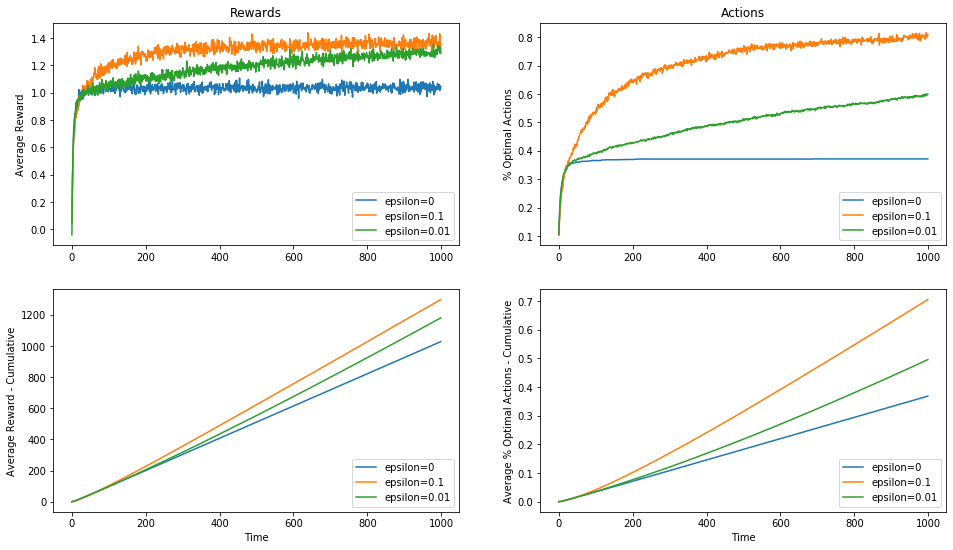

In [25]:
# Problem setup
k = 10 # Number of actions, i.e., how many arms the bandit has.
total_runs  = 2000 # Number of randomly generated k-armed bandit problems .
T = 1000 # Total of time steps per instance.

# Variance parameter for rewards sampling.
rewards_var = 1

# Epsilon values for epsilon-greedy action selection method. A value of 0.0 means greedy.
epsilon_values = [0, 0.1, 0.01] 

# Returns for all simulations
returns = {} 

# Printing info
print('#General Info:')
print('k = {}, total_runs = {}, T = {}'.format(k, total_runs, T))
print('rewards_var = {}\n'.format(rewards_var))

for epsilon in epsilon_values:
    start = time.time()
    print('Running epsilon = {}...'.format(epsilon))
    t_Q, t_R, t_opt_A = simulate(k, rewards_var, epsilon, T, total_runs)
    returns['epsilon='+str(epsilon)] = {'Q':t_Q, 
                                        'R':t_R, 
                                        'opt_A':t_opt_A}
    print('finished in {} min'.format(timedelta(seconds=time.time() - start)/60), flush=True)

# Visual
plot_results(returns)

#General Info:
k = 10, total_runs = 2000, T = 1000
rewards_var = 10

Running epsilon = 0...
finished in 0:00:03.649162 min
Running epsilon = 0.1...
finished in 0:00:03.776353 min
Running epsilon = 0.01...
finished in 0:00:03.720100 min


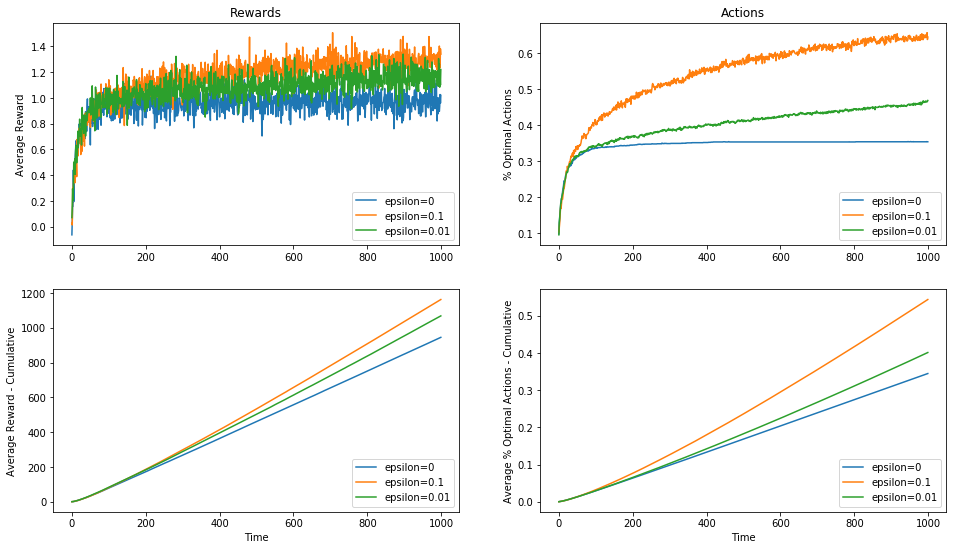

In [27]:
# Problem setup
k = 10 # Number of actions, i.e., how many arms the bandit has.
total_runs  = 2000 # Number of randomly generated k-armed bandit problems .
T = 1000 # Total of time steps per instance.

# Variance parameter for rewards sampling.
rewards_var = 10

# Epsilon values for epsilon-greedy action selection method. A value of 0.0 means greedy.
epsilon_values = [0, 0.1, 0.01] 

# Returns for all simulations
returns = {} 

# Printing info
print('#General Info:')
print('k = {}, total_runs = {}, T = {}'.format(k, total_runs, T))
print('rewards_var = {}\n'.format(rewards_var))

for epsilon in epsilon_values:
    start = time.time()
    print('Running epsilon = {}...'.format(epsilon))
    t_Q, t_R, t_opt_A = simulate(k, rewards_var, epsilon, T, total_runs)
    returns['epsilon='+str(epsilon)] = {'Q':t_Q, 
                                        'R':t_R, 
                                        'opt_A':t_opt_A}
    print('finished in {} min'.format(timedelta(seconds=time.time() - start)/60), flush=True)

# Visual
plot_results(returns)

#General Info:
k = 10, total_runs = 2000, T = 1000
rewards_var = 0

Running epsilon = 0...
finished in 0:00:03.804969 min
Running epsilon = 0.1...
finished in 0:00:03.788987 min
Running epsilon = 0.01...
finished in 0:00:03.676913 min


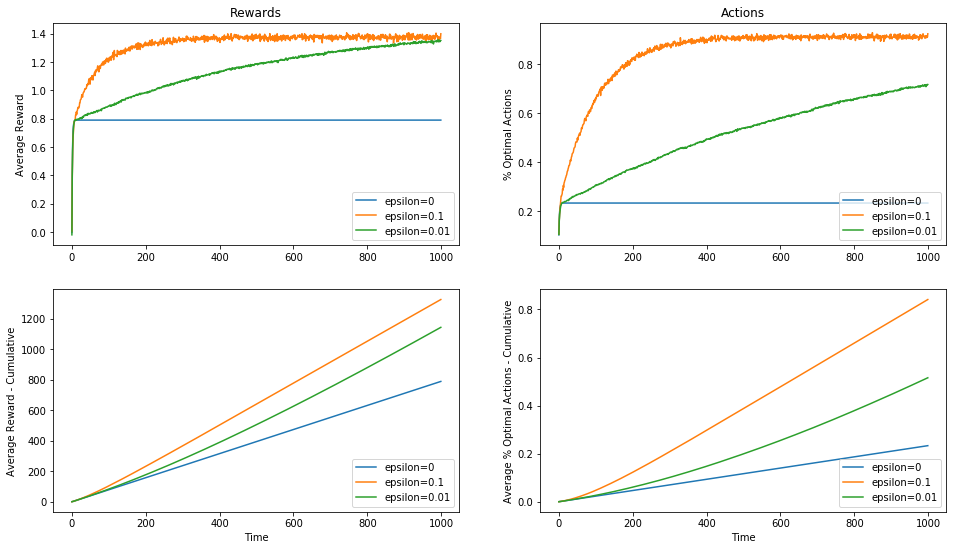

In [28]:
# Problem setup
k = 10 # Number of actions, i.e., how many arms the bandit has.
total_runs  = 2000 # Number of randomly generated k-armed bandit problems .
T = 1000 # Total of time steps per instance.

# Variance parameter for rewards sampling.
rewards_var = 0

# Epsilon values for epsilon-greedy action selection method. A value of 0.0 means greedy.
epsilon_values = [0, 0.1, 0.01] 

# Returns for all simulations
returns = {} 

# Printing info
print('#General Info:')
print('k = {}, total_runs = {}, T = {}'.format(k, total_runs, T))
print('rewards_var = {}\n'.format(rewards_var))

for epsilon in epsilon_values:
    start = time.time()
    print('Running epsilon = {}...'.format(epsilon))
    t_Q, t_R, t_opt_A = simulate(k, rewards_var, epsilon, T, total_runs)
    returns['epsilon='+str(epsilon)] = {'Q':t_Q, 
                                        'R':t_R, 
                                        'opt_A':t_opt_A}
    print('finished in {} min'.format(timedelta(seconds=time.time() - start)/60), flush=True)

# Visual
plot_results(returns)

# -----------------------------------------------------------------------------------------------------------